In [1]:
from cassiemujocoik_ctypes import *
import matplotlib.pyplot as plt
%matplotlib inline
import time
import array
import numpy as np
import pickle
import os

In [2]:
class CassieIK(object):
    def __init__(self, sim_steps=30, render_sim=True):
        self.sim = mujSimulation(render_sim)
        self.sim_steps = sim_steps
        self.render_sim = render_sim
        # qpos we want as output from ik
        self.qpos = array.array('d', [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
        self.qpos = (ctypes.c_double * 35) (*self.qpos)

    def single_pos_ik(self, traj_pos):
        # foot position we want to go to
        traj_pos_arr = array.array('d', traj_pos)
        # convert foot positions to c array
        traj_pos_arr_c = (ctypes.c_double * 9) (*traj_pos_arr)

        # use wrapper to get ik
        qpos = self.sim.fetch_cassie_ik(traj_pos_arr_c, steps=self.sim_steps)

        return np.array(qpos[:35])

    def trajectory_ik(self, trajectory):
        traj_qpos = np.zeros((len(trajectory), 35))
        for i in range(len(trajectory)):
            traj_qpos[i] += self.single_pos_ik(trajectory[i])
        
        # Now we gotta estimate the qvels using finite difference estimates of d qpos / dt
        # only do this for the motor positions
        motor_indices = [7, 8, 9, 14, 20, 21, 22, 23, 28, 34]
        traj_qvel = np.zeros((len(trajectory), len(motor_indices)))
        for i in range(len(traj_qpos)):
            traj_qvel[i] += np.take((traj_qpos[i] - traj_qpos[i - 1]) / (1/2000), motor_indices)

        full_trajectory = {"qpos": traj_qpos, "qvel": traj_qvel}
        with open("trajectory/spline_stepping_traj.pkl", "wb") as f:
            pickle.dump(full_trajectory, f)
            print("wrote pickle file")
            
        return traj_qpos, traj_qvel

In [3]:
# From cubic spline for now
from scipy.interpolate import CubicSpline

def get_trajectory(peak, stride, phase, stance=0.15):
    """
    Foot and center of mass trajectory generator

    The center of mass trajectory is a line q(t) = (x(t), 0, z). 

    The foot trajectories are periodic 3 point cubic splines in z(t),
    lines in x(t), and constant in y => q(t) = (x(t), y, z(t))

    Left and right foot trajectories are offset in time by "phase" timesteps.
    """
    # TODO: figure out formula for how com_vel relates to foot trajectories...
    # is SLIP model necessary?
    com_vel = 0.02

    t = np.arange(phase)

    m = stride / phase

    ts = np.array([0, phase / 2, phase - 1])
    zs = np.array([0, peak, 0])
    spline = CubicSpline(ts, zs)

    x = m * t
    z = spline(t)
    
    # left foot steps first
    x_l = np.concatenate((x, np.ones(phase) * x[-1]))
    y_l = np.ones(phase * 2) * -stance
    z_l = np.concatenate((z, np.zeros(phase)))

    # then right foot
    x_r = np.concatenate((np.ones(phase) * x[0] + stride / 2, x + stride / 2))
    y_r = np.ones(phase * 2) * stance
    z_r = np.concatenate((np.zeros(phase), z))

    x_com = np.cumsum(np.ones(phase * 2) * com_vel)
    y_com = np.zeros(phase * 2)
    z_com = np.ones(phase * 2) * 1

    return np.column_stack([x_l, y_l, z_l, 
                       x_r, y_r, z_r, 
                       x_com, y_com, z_com])

In [4]:
def get_trajectory_from_ref_foot_pos():
    from trajectory import CassieTrajectory
    traj = CassieTrajectory("helei_reference_foot_data/stepdata.bin")

    os.path.abspath('')
    foot_pos = traj.foot_pos
    foot_vel = traj.foot_vel

    com_vel = 0.02

    pelvis_height = 1

    # pelvis coordinates
    x_com = traj.qpos[:,0]
    y_com = traj.qpos[:,1]
    z_com = traj.qpos[:,2]

    # left foot steps first
    x_l = foot_pos[:,0] + x_com
    y_l = foot_pos[:,1] + y_com
    z_l = foot_pos[:,2] + z_com

    # then right foot
    x_r = foot_pos[:,3] + x_com
    y_r = foot_pos[:,4] + y_com
    z_r = foot_pos[:,5] + z_com

    return np.column_stack([x_l, y_l, z_l, 
                       x_r, y_r, z_r, 
                       x_com, y_com, z_com])

In [5]:
feet_trajectory = get_trajectory_from_ref_foot_pos()
#feet_trajectory = get_trajectory(0.2, 0.0, 825)

print(feet_trajectory.shape)

cassie = CassieIK(sim_steps=1, render_sim=True)
traj_qpos, traj_qvel = cassie.trajectory_ik(feet_trajectory)

(1682, 9)
wrote pickle file


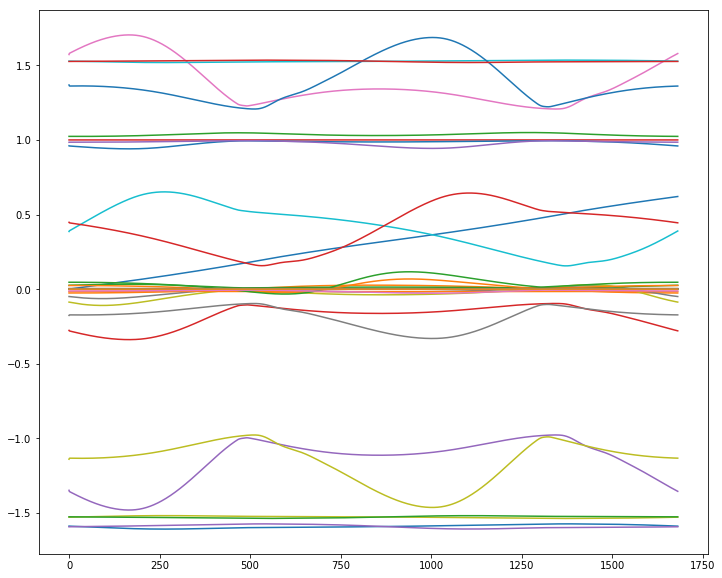

In [6]:
fig = plt.figure(figsize=(12,10))
qposes = fig.add_subplot(111)
qposes.plot(traj_qpos)
plt.show()

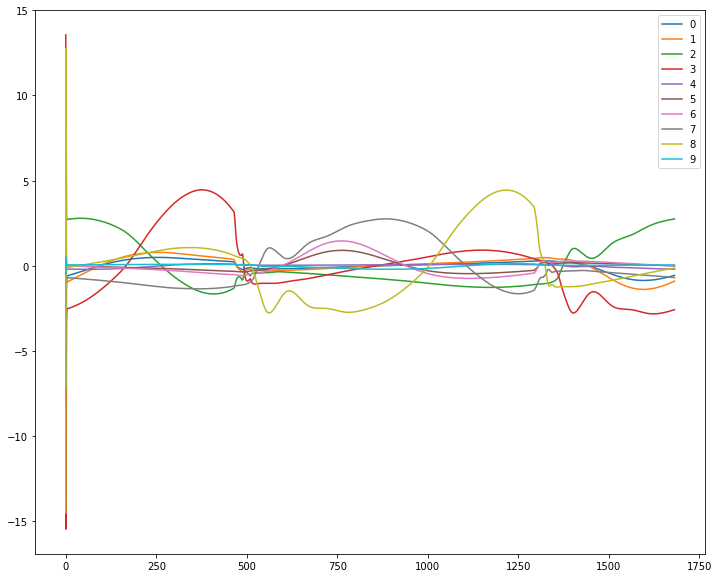

In [7]:
fig2 = plt.figure(figsize=(12,10))
qvels = fig2.add_subplot(111)
qvels.plot(traj_qvel)
qvels.legend(np.arange(10))
plt.show()

In [8]:
traj_qpos.shape

(1682, 35)

In [9]:
traj_qpos

array([[ 0.00000000e+00, -2.59340312e-02,  1.02381778e+00, ...,
        -1.52627899e+00,  1.52606107e+00, -1.59325043e+00],
       [ 3.26319510e-04, -2.59372052e-02,  1.02380753e+00, ...,
        -1.52641500e+00,  1.52617966e+00, -1.59299525e+00],
       [ 6.52569579e-04, -2.59400904e-02,  1.02379775e+00, ...,
        -1.52644217e+00,  1.52620332e+00, -1.59294430e+00],
       ...,
       [ 6.20082796e-01, -2.59322654e-02,  1.02384210e+00, ...,
        -1.52638952e+00,  1.52615760e+00, -1.59304289e+00],
       [ 6.20413423e-01, -2.59332862e-02,  1.02382970e+00, ...,
        -1.52640311e+00,  1.52616944e+00, -1.59301740e+00],
       [ 6.20743930e-01, -2.59340312e-02,  1.02381778e+00, ...,
        -1.52641673e+00,  1.52618131e+00, -1.59299185e+00]])